**A. Caner Turkmen**

First we generate samples from the 2-norm ball. We first use inversion method to draw samples from $p(r)$. Note that:

$$
F_{X}(x) = \int_{0}^{x} p(x') dx' = \int_{0}^{x} 2x' dx' = x^2
$$

We have that $F^{-1}_X(u) = \sqrt{u}$ since we have $x \ge 0$ by definition. Then if we draw $u$ from $Uniform(0,1)$, $F^{-1}_X(u)$ would correspond to samples from $p(x)$.

.. and they look random enough.

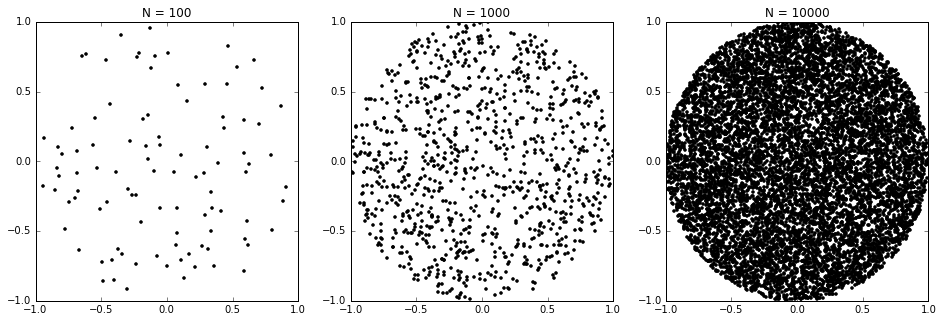

In [13]:
%matplotlib inline
import numpy as np
from numpy.random import rand as randu
from matplotlib import pyplot as pl

def sample_circle(n=1):
    """
    Sample from the unit 2-norm ball as given in the instructions
    """
    theta = randu(n) * 2 * np.pi
    r = np.sqrt(randu(n)) # vector of radii
    
    return r, theta

def to_cartesian(r, theta):
    x = r * np.sin(theta)
    y = r * np.cos(theta)
    return x,y

f, ax = pl.subplots(1,3, figsize=(16,5))

for k in range(3):
    N = int(10**(k+2))
    r, theta = sample_circle(N)
    x, y = to_cartesian(r, theta)
    
    ax[k].set_title("N = %d" % N)
    ax[k].plot(x, y, 'k.')

We now sample from the 2-norm ball and accept samples from the 1.5 and .7 norms.

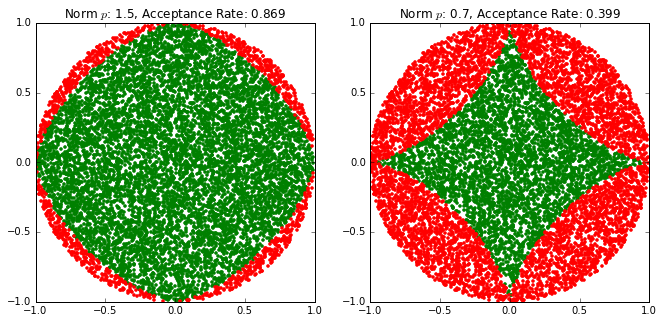

In [23]:
r, theta = sample_circle(10000)
x, y = to_cartesian(r, theta)
X = np.c_[x,y]

f, ax = pl.subplots(1, 2, figsize=(11,5))

for i, o in enumerate([1.5, .7]):
    in_ball = np.linalg.norm(X, o, axis=1) <= 1

    ax[i].set_title("Norm $p$: %.1f, Acceptance Rate: %.3f" % (o, np.mean(in_ball)))
    ax[i].plot(x[in_ball], y[in_ball], 'g.')
    ax[i].plot(x[~in_ball], y[~in_ball], 'r.')

The acceptance rate for .7-(quasi)-norm is quite low. We can improve by sampling inside the 1-norm ball. 

To sample from the 1-norm ball, we employ a trick. We sample from infinity norm ball with norm = $1 / \sqrt{2}$ (basically, a square with boundaries at x, y = $-1 / \sqrt{2}$ or $1 / \sqrt{2}$. We then rotate the samples by $\pi / 4$. We show how the approach works below, and perform rejection sampling.

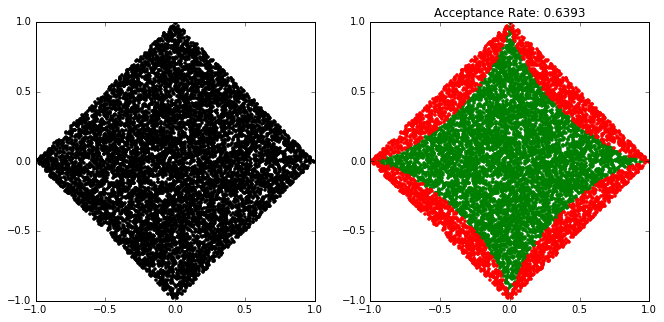

In [37]:
def sample_1norm(N=1):
    
    sq2i = 1 / np.sqrt(2)
    
    x = (randu(N) - .5) * 2 * sq2i
    y = (randu(N) - .5) * 2 * sq2i

    X = np.c_[x,y]

    def get_rot_matrix(theta):
        return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    rot = get_rot_matrix(np.pi / 4)

    return X.dot(rot.T) # rotated samples

R = sample_1norm(10000)


f, ax = pl.subplots(1, 2, figsize=(11,5))
ax[0].plot(R[:,0], R[:,1], 'k.')

in_ball = np.linalg.norm(R, .7, axis=1) <= 1
ax[1].set_title("Acceptance Rate: %.4f" % np.mean(in_ball))
ax[1].plot(R[in_ball,0], R[in_ball,1], 'g.')
ax[1].plot(R[~in_ball,0], R[~in_ball,1], 'r.')

We now perform rejection sampling on the 1-norm ball.

# Bonus

To sample from the n-sphere, we must place more weight towards the outer shell. In two dimensions the n-sphere shell volume is proportional to $r^2$. In general, we know it is proportional to $r^n$. Following the same line of intuition, we can sample a uniform radius and take it through the transformation $u^{1/n}$ to obtain the radius parameter. We implement the approach below:

In [136]:
def generate_from_nsphere(N=1, d=2):
    """
    Generate random samples from the n-sphere in d dimensions.
    
    :param d: number of dimensions, samples will reside in R^d
    :param N: number of samples
    """
    if d <= 1:
        raise ValueError("dimension should be >= 2")
    
    dr = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=N)
    dr = dr.T / np.linalg.norm(dr, 2, axis=1)
    
    r = np.power(randu(N), 1./d)
    
    return (dr * r).T

def generate_from_ncube(N=1, d=2):
    return randu(N, d) * 2 - 1

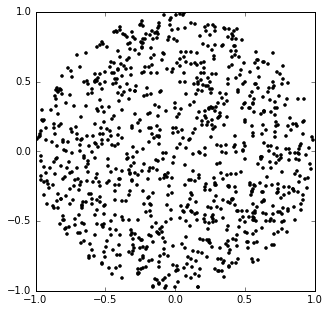

In [141]:
X = generate_from_nsphere(1000, d=2)
pl.figure(figsize=(5,5))
pl.plot(X[:,0], X[:,1], "k.")

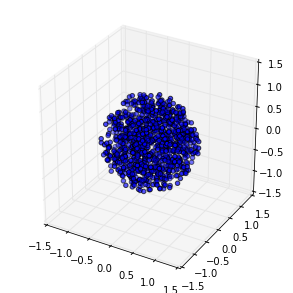

In [140]:
from mpl_toolkits.mplot3d import Axes3D
X = generate_from_nsphere(1000, d=3)

fig = pl.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2])
pl.show()


We provide a loose demonstration of how the acceptance rate should decrease as dimensionality increases. In general, for $2k$ dimensions, the volume of the n-cube that encapsulates the unit n-sphere is given by $2^{2k}$. The volume of the n-sphere is given by (see Wikipedia):

$$
V_{2k} = \frac{\pi^k}{k!}
$$

using Stirling's approximation this is approximately equal to:

$$
V_{2k} \approx \frac{\pi^k}{\sqrt{2 \pi k} (\frac{k}{e})^{k}}
$$

then the expected acceptance rate becomes:

$$
f(2k) \approx \frac{\pi^k}{\sqrt{2 \pi k} (\frac{4k}{e})^{k}}
$$

equivalently:

$$
f(2k) \approx \left( \frac{\pi e}{4k} \right)^{k} \frac{1}{\sqrt{2\pi k}}
$$

It is easy to observe that $\lim_{k \rightarrow \infty} f(2k) = 0$ and the decrease is at a super-exponential rate. 

Fun fact: the chances of winning the Sayisal Loto is $1 / \binom{49}{6}$. This is about $7.15 \times 10^{-8}$. Which means that by the time you go up to 20 dimensions, your chances of landing in the unit sphere are less than winning Sayisal Loto.

In [83]:
def accept_approx(k):
    """
    An approximation to the acceptance rate to sample from the unit n-sphere, when performing
    rejection sampling over the bounding n-cube.
    """
    if k % 2 != 0:
        raise ValueError()
    k /= 2
    
    return ((np.pi * np.e) / (4*k))**k / (np.sqrt(2 * np.pi * k))

In [97]:
print "%.3e" % accept_approx(20)

2.482e-08


We confirm with a short simulation.

In [100]:
arr = []

for d in range(3,20):
    X = generate_from_ncube(int(1e7), d)
    in_ball = np.linalg.norm(X, 2, axis=1) <= 1
    
    arr.append(np.mean(in_ball))

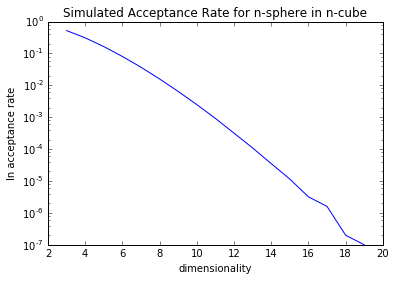

In [106]:
pl.title('Simulated Acceptance Rate for n-sphere in n-cube')
pl.yscale('log')
pl.ylabel('ln acceptance rate')
pl.xlabel('dimensionality')
pl.plot(range(3,20),arr)